In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pyhf
import matplotlib.pyplot as plt
from publik.pyhf_modifier import modifier

In [2]:
def null_dist(x, a=1., h1=2., h2=0.):
    return a*(1+x*h1-x**2*h2)

def alt_dist(x, a=1., h1=1., h2=1.):
    return a*(1-x*h1+x**2*h2)

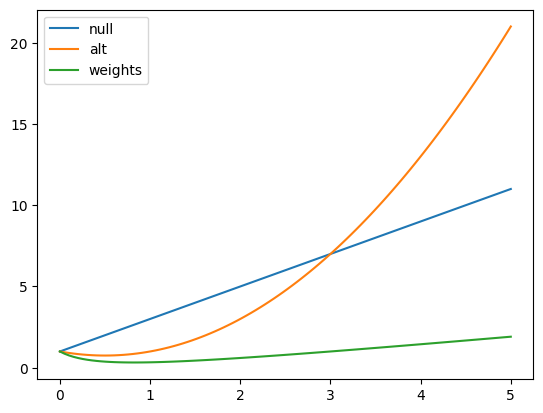

In [3]:
x = np.linspace(0,5,100)
plt.plot(x, null_dist(x), label='null')
plt.plot(x, alt_dist(x, 1), label='alt')
plt.plot(x, alt_dist(x, 1)/null_dist(x), label='weights')
plt.legend()

[0.80555556 1.22916667]


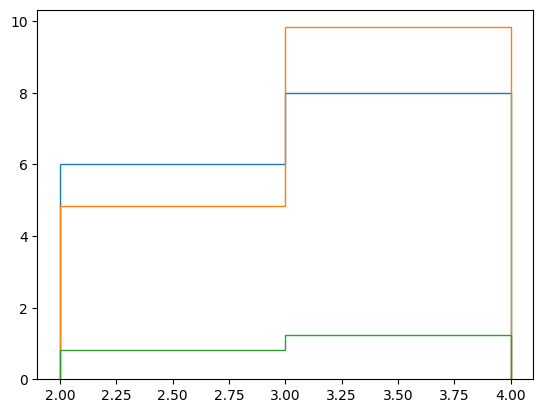

In [4]:
binning = np.array([2.,3.,4.])
bin_cents = (binning[:-1] + binning[1:])/2
null = modifier.bintegrate(null_dist, binning)
alt = modifier.bintegrate(alt_dist, binning, (1,1))

plt.stairs(null, binning)
plt.stairs(alt, binning)
plt.stairs(alt/null, binning)
print(alt/null)

In [5]:
# Set up the custom modifier
mapping_dist = np.array([[5.,0], [0,10.]])

new_params = {
                'a'   :{'inits': (1.,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'h'   :{'inits': (1.,1.), 'bounds': ((0., 5.),(1., 6.)), 'cov': [[1.,0.5],[0.5,1.]], 'paramset_type': 'constrained_by_normal'}
            }

expanded_pyhf = modifier.add(new_params, alt_dist, null_dist, mapping_dist, binning)
expanded_pyhf

{'custom': (publik.pyhf_modifier.custom_modifier.add.<locals>._builder,
  publik.pyhf_modifier.custom_modifier.add.<locals>._applier),
 'histosys': (pyhf.modifiers.histosys.histosys_builder,
  pyhf.modifiers.histosys.histosys_combined),
 'lumi': (pyhf.modifiers.lumi.lumi_builder, pyhf.modifiers.lumi.lumi_combined),
 'normfactor': (pyhf.modifiers.normfactor.normfactor_builder,
  pyhf.modifiers.normfactor.normfactor_combined),
 'normsys': (pyhf.modifiers.normsys.normsys_builder,
  pyhf.modifiers.normsys.normsys_combined),
 'shapefactor': (pyhf.modifiers.shapefactor.shapefactor_builder,
  pyhf.modifiers.shapefactor.shapefactor_combined),
 'shapesys': (pyhf.modifiers.shapesys.shapesys_builder,
  pyhf.modifiers.shapesys.shapesys_combined),
 'staterror': (pyhf.modifiers.staterror.staterror_builder,
  pyhf.modifiers.staterror.staterror_combined)}

In [6]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [5.0, 10.0],
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            }
          ]
        },
        {
          "name": "background",
          "data": [50.0, 60.0],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [5.0, 12.0]
            }
          ]
        }
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [0, 1]
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], expanded_pyhf, custom_mod)
data = [58., 85.] + model.config.auxdata
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [5.0, 10.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function', 'ibin': [0, 1]}}]},
    {'name': 'background',
     'data': [50.0, 60.0],
     'modifiers': [{'name': 'uncorr_bkguncrt',
       'type': 'shapesys',
       'data': [5.0, 12.0]}]}]}]}

In [7]:
model.config.par_map

{'a': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x1498f7c0c340>},
 'h_decorrelated[0]': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x1498f7c0c370>},
 'h_decorrelated[1]': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x1498f7c0c3a0>},
 'mu': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x1498f7c0c490>},
 'uncorr_bkguncrt': {'slice': slice(4, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x1498f7c0c4c0>}}

In [8]:
model.config.suggested_init()

[1.0, 0.0, 0.0, 1.0, 1.0, 1.0]

In [9]:
init = model.config.suggested_init()
init[0] = 2.
init[1] = -0.2
init[2] = -0.2

list(model.expected_actualdata(init))

[57.68992134928011, 84.44994553338127]

In [10]:
fixed = model.config.suggested_fixed()
fixed[3] = True

best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
best_fit

array([ 2.02316112e+00, -1.39934214e-03, -1.55871342e-03,  1.00000000e+00,
        9.99123186e-01,  1.00140539e+00])

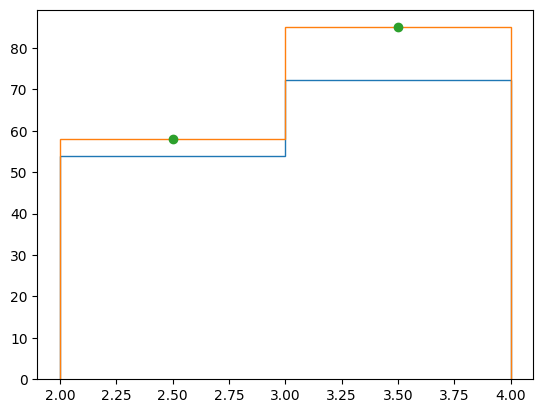

In [11]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit), binning)
plt.plot(bin_cents, data[:2], "o")